## HDDM Analysis of Pizzagalli et al 2008

In [2]:
import datetime, mmap,os,re, sys, decimal, hddm
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy as sp
from patsy import dmatrix
import warnings 
warnings.filterwarnings('ignore')# I'm sick of all the red.
os.environ['R_HOME'] = '/Users/mlm2/anaconda/envs/pythonthreefive/lib/R' # couldn't find R in this environment for some reason
% matplotlib inline 
% reload_ext rpy2.ipython
%R library(lsmeans)
%R library(afex)
%R library(ppcor)

array(['ppcor', 'MASS', 'afex', 'reshape2', 'lme4', 'Matrix', 'lsmeans',
       'estimability', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], 
      dtype='<U12')

## Getting the data together  
Most of this was taken from the PRT_Prettier notebook, with a few adjustments.  
TO DO: Consider replacing '/' with another character for less headache later

In [39]:
uname = !whoami
uname = uname[0]
path2analysis = '/Users/' + uname + '/Work/Expts/SIGDEP/Data/Analysis/' # also where git repo lives
path2data = '/Users/' + uname + '/Work/Expts/SIGDEP/Data/PostApril04_Data/TIME_1/'
today = datetime.datetime.today().strftime("%m_%d_%Y")

In [195]:
def SigDetParse(fname):
    '''Open the file, use regex to pull out key vars, output a clean df.'''
    
    df = []
    d = {}
    ct = 0
    
    # Begin reading in data from the line including 'reward_due', as that's unlikely to occur anywhere earlier
    with open(fname) as f:
        for line in f:
            if 'reward_due' in line:
                for line in f:
                    d[ct] = {'trial':line.split('\t')[0],
                             'length':line.split('\t')[1],
                             'time':line.split('\t')[2], # tempting to change to RT but keep same for backwards compat
                             'key_press':line.split('\t')[3],
                             'correct':line.split('\t')[4],
                             'did_reward':line.split('\t')[5],
                             'reward_due':line.split('\t')[6],
                             'short_due':line.split('\t')[7],
                             'long_due':line.split('\t')[8],
                             'outlier':line.split('\t')[9].strip('\n')}
                    ct = ct + 1
    df = pd.DataFrame.from_dict(d,orient='index')
    

    for val in [('subject','Subject ID:'), ('date','Date:'), ('bias','Bias:'), ('short_key','Key for short mouth:'), ('long_key','Key for long mouth:'),
               ('response_bias', 'RB_adjst_all:'), ('discriminability','dis_adjst_all:')]:
        
        var_name, pattern = val
        if var_name != 'long_key' and var_name != 'short_key':
            df[var_name] = np.nan
        elif var_name == 'long_key' or var_name == 'short_key':
            df[var_name] = 'z'
        # Need some default values b/c some subjects have missing data        

        if var_name == 'date':
            var_def = re.compile(pattern + '[\s]+([\d]+/[\d]+/[\d]+)')
        elif var_name == 'short_key' or var_name == 'long_key':
            var_def = re.compile(pattern + '[\s]+(/)')
        elif var_name == 'response_bias' or var_name == 'discriminability':
            var_def = re.compile(pattern + '[\s]+([\d]+.[\d][\d][\d][\d])')
            var_def_neg = re.compile(pattern + '[\s]+(-[\d]+.[\d][\d][\d][\d])')
        else:
            var_def = re.compile(pattern + '[\s]+([\w]+)')
        
        if var_name != 'response_bias' and var_name != 'discriminability':
            with open(fname) as f:
                for line in f:
                    var_match = var_def.search(line)
                    if var_match:
                        result = var_match.group(1)
                        df[var_name] = result
        else: # it gets a little tricky here because discriminability and response bias appear multiple times throughout 
            done = 'false' # the file. For now, we just want the first tim (the "overall"). It also gets hairy bc response 
            with open(fname) as f: # bias can be negative
                    for line in f:
                        if done == 'false':
                            var_match = var_def.search(line)
                            var_match_neg = var_def_neg.search(line)
                            if var_match:
                                result = var_match.group(1)
                                df[var_name] = result
                                done = 'true'
                            elif var_match_neg:
                                result = var_match_neg.group(1)
                                df[var_name] = result
                                done = 'true'
    return df

In [196]:
raw_files = path2data + 'done/SigDet' + '*.txt.out'
raw_files = !ls {raw_files}
dfs = []
for file in raw_files:
    statinfo = os.stat(file) # checking for empty files
    if statinfo.st_size == 0:
        print ('Empty file: '+ file)
    else:
        df = SigDetParse(file)
        dfs.append(df)
out = pd.DataFrame
out = pd.concat(dfs)
out = out[['subject','date','bias','short_key', 'long_key','trial','length','time','key_press','correct','did_reward','reward_due','short_due','long_due','outlier',
          'discriminability', 'response_bias']]
out.subject = out.subject.astype(str).apply(lambda x: x.zfill(3))

**Note:** The response bias and discriminability columns are overall scores (from trials 0-299)

In [197]:
out.head()

,subject,date,bias,short_key,long_key,trial,length,time,key_press,correct,did_reward,reward_due,short_due,long_due,outlier,discriminability,response_bias
0,032,5/11/2004,short,z,/,1,short,546,/,0,0,0,0,0,0,0.8603,-0.1070
1,032,5/11/2004,short,z,/,2,long,738,/,1,1,1,0,0,0,0.8603,-0.1070
2,032,5/11/2004,short,z,/,3,short,815,z,1,1,1,0,0,0,0.8603,-0.1070
3,032,5/11/2004,short,z,/,4,long,625,/,1,0,0,0,0,0,0.8603,-0.1070
4,032,5/11/2004,short,z,/,5,short,1267,z,1,0,0,0,0,0,0.8603,-0.1070


In [198]:
out.subject.nunique()

90

In [199]:
out.subject.unique()

array(['032', '033', '034', '035', '036', '037', '038', '039', '040',
       '041', '042', '043', '044', '045', '060', '061', '062', '063',
       '064', '065', '066', '067', '068', '069', '070', '071', '072',
       '073', '074', '075', '076', '077', '078', '079', '080', '081',
       '082', '083', '084', '085', '086', '087', '088', '089', '090',
       '091', '092', '093', '094', '095', '096', '097', '098', '099',
       '100', '101', '102', '103', '104', '105', '106', '107', '108',
       '109', '110', '111', '112', '113', '114', '115', '116', '117',
       '118', '119', '120', '121', '046', '047', '048', '049', '050',
       '051', '052', '053', '054', '055', '056', '057', '058', '059'], dtype=object)

In [40]:
groups = pd.read_csv(path2data + 'sigdep_groups.csv')
groups = groups[['Subject','exclude', 'group', 'age', 'sex', 'BDItotal', 'Pure_Anhed', 'RB_adjst_all1_1', 
                 'RB_adjst_all1_2', 'RB_adjst_all1_3', 'dis_adjst_all1_1', 'dis_adjst_all1_2', 'dis_adjst_all1_3', 
                'avT1_4', 'avT1_1', 'avrhT1_1', 'avlnT1_1', 'avshT1_1', 'avlgT1_1', 'avT1_2', 'avrhT1_2', 'avlnT1_2',
                'avshT1_2', 'avlgT1_2', 'avT1_3', 'avrhT1_3', 'avlnT1_3', 'avshT1_3', 'avlgT1_3', 'MASQ_AD',
                'avrhT1_4', 'avlnT1_4', 'avshT1_4', 'avlgT1_4']] 
groups = groups.rename(index = str, columns={'Subject': 'subject'})
groups.subject = groups.subject.astype(str).apply(lambda x: x.zfill(3))
groups.head()

,subject,exclude,group,age,sex,BDItotal,Pure_Anhed,RB_adjst_all1_1,RB_adjst_all1_2,RB_adjst_all1_3,...,avT1_3,avrhT1_3,avlnT1_3,avshT1_3,avlgT1_3,MASQ_AD,avrhT1_4,avlnT1_4,avshT1_4,avlgT1_4
0,039,0.0,MDD,53,f,40,11,0.257556,0.259358,0.061919,...,651.353516,573.020386,728.119995,573.020386,728.119995,100.0,653.275146,734.02002,653.275146,734.02002
1,040,1.0,MDD,29,f,20,5,0.222434,0.258315,0.214273,...,458.216858,465.333344,450.926819,465.333344,450.926819,92.0,507.884613,495.29135,507.884613,495.29135
2,041,0.0,MDD,43,m,28,4,0.072285,-0.063303,-0.043575,...,470.151520,479.040009,461.081635,461.081635,479.040009,94.0,505.691284,537.52026,537.520264,505.69128
3,046,0.0,MDD,42,m,27,10,0.189317,0.435575,0.243272,...,329.297882,279.088898,375.408173,375.408173,279.088898,93.0,343.820679,427.25851,427.258514,343.82068
4,047,0.0,MDD,44,f,44,7,0.150296,0.188995,0.234880,...,841.397949,831.708313,850.700012,831.708313,850.700012,95.0,697.289673,764.16895,697.289673,764.16895


In [202]:
groups.subject.unique()

array(['039', '040', '041', '046', '047', '049', '050', '051', '052',
       '053', '054', '055', '056', '057', '058', '059', '060', '061',
       '062', '063', '064', '065', '066', '067', '068', '069', '070',
       '071', '072', '073', '074', '075', '076', '077', '078', '079',
       '080', '081', '082', '083', '084', '085', '086', '087', '088',
       '089', '090', '091', '092', '093', '094', '095', '096', '097',
       '098', '099', '100', '101', '102', '103', '104', '105', '106',
       '107', '108', '109', '110', '111', '112', '113', '114', '115',
       '116', '117', '118', '119', '120', '121'], dtype=object)

In [203]:
data = out.merge(groups, how='outer')
data = data[pd.notnull(data['group'])] # the groups file doesn't have 32-38 (prob pilots)
data = data[data.group != 'BIPOLAR'] # only care about MDD vs CTL (for now!)
data = data[data.exclude != 1] # get rid of three people that Diego excluded for > 40 outlier trials
data = data[data.outlier != '1'] # get rid of the outlier trials
data.head() 

,subject,date,bias,short_key,long_key,trial,length,time,key_press,correct,...,avT1_3,avrhT1_3,avlnT1_3,avshT1_3,avlgT1_3,MASQ_AD,avrhT1_4,avlnT1_4,avshT1_4,avlgT1_4
2100,039,6/15/2004,short,/,z,1,short,499,/,1,...,651.353516,573.020386,728.119995,573.020386,728.119995,100.0,653.275146,734.02002,653.275146,734.02002
2101,039,6/15/2004,short,/,z,2,long,628,z,1,...,651.353516,573.020386,728.119995,573.020386,728.119995,100.0,653.275146,734.02002,653.275146,734.02002
2102,039,6/15/2004,short,/,z,3,short,705,/,1,...,651.353516,573.020386,728.119995,573.020386,728.119995,100.0,653.275146,734.02002,653.275146,734.02002
2103,039,6/15/2004,short,/,z,4,long,588,z,1,...,651.353516,573.020386,728.119995,573.020386,728.119995,100.0,653.275146,734.02002,653.275146,734.02002
2104,039,6/15/2004,short,/,z,5,short,667,z,0,...,651.353516,573.020386,728.119995,573.020386,728.119995,100.0,653.275146,734.02002,653.275146,734.02002


In [204]:
data.outlier.unique()

array(['0'], dtype=object)

In [205]:
data.subject.nunique() # getting closer, we have two more than they do. 

50

In [206]:
data.groupby('group').subject.nunique() # looks like 2 more controls were excluded

group
CON    27
MDD    23
Name: subject, dtype: int64

I found another file that has a list of all participants and who was included, looks like two more controls were excluded (063 & 069), which fits nicely!

In [207]:
final_include = pd.read_csv(path2data + 'IncludedFinalAnalyses_20july07.csv')
final_include = final_include.rename(index = str, columns = {'subID': 'subject'})
final_include.subject = final_include.subject.astype(str).apply(lambda x: x.zfill(3))
data = data.merge(final_include, on = 'subject', how = 'outer')
data = data[pd.notnull(data['group'])] # do this again
data = data[data.excluded == 0]
data = data[data.outlier == '0']

In [208]:
data.head(5)

,subject,date,bias,short_key,long_key,trial,length,time,key_press,correct,...,avshT1_3,avlgT1_3,MASQ_AD,avrhT1_4,avlnT1_4,avshT1_4,avlgT1_4,excluded,Group#,Group
0,039,6/15/2004,short,/,z,1,short,499,/,1,...,573.020386,728.119995,100.0,653.275146,734.02002,653.275146,734.02002,0,0,MDD
1,039,6/15/2004,short,/,z,2,long,628,z,1,...,573.020386,728.119995,100.0,653.275146,734.02002,653.275146,734.02002,0,0,MDD
2,039,6/15/2004,short,/,z,3,short,705,/,1,...,573.020386,728.119995,100.0,653.275146,734.02002,653.275146,734.02002,0,0,MDD
3,039,6/15/2004,short,/,z,4,long,588,z,1,...,573.020386,728.119995,100.0,653.275146,734.02002,653.275146,734.02002,0,0,MDD
4,039,6/15/2004,short,/,z,5,short,667,z,0,...,573.020386,728.119995,100.0,653.275146,734.02002,653.275146,734.02002,0,0,MDD


In [209]:
data.groupby('group').subject.nunique() # Wohoo, looks like we're there!

group
CON    25
MDD    23
Name: subject, dtype: int64

In [210]:
data.subject.unique()

array(['039', '041', '061', '062', '064', '065', '066', '067', '068',
       '069', '070', '071', '072', '073', '074', '075', '076', '077',
       '078', '079', '092', '094', '097', '098', '100', '104', '106',
       '108', '109', '111', '112', '113', '114', '115', '116', '118',
       '046', '047', '049', '050', '051', '052', '054', '055', '056',
       '057', '058', '059'], dtype=object)

In [211]:
data.response_bias = pd.to_numeric(data.response_bias)
data.discriminability = pd.to_numeric(data.discriminability)

In [212]:
# add block info
data['trial'] = pd.to_numeric(data['trial'])
data.loc[data['trial'] <= 100, 'block'] = 1
data.loc[(data['trial'] > 100) & (data['trial'] <= 200), 'block'] = 2
data.loc[data['trial'] > 200, 'block'] = 3

In [213]:
#checking that that looks okay
data.groupby('block').count()

,subject,date,bias,short_key,long_key,trial,length,time,key_press,correct,...,avshT1_3,avlgT1_3,MASQ_AD,avrhT1_4,avlnT1_4,avshT1_4,avlgT1_4,excluded,Group#,Group
block,,,,,,,,,,,,,,,,,,,,,
1.0,4700,4700,4700,4700,4700,4700,4700,4700,4700,4700,...,4700,4700,4700,4700,4700,4700,4700,4700,4700,4700
2.0,4739,4739,4739,4739,4739,4739,4739,4739,4739,4739,...,4739,4739,4739,4739,4739,4739,4739,4739,4739,4739
3.0,4720,4720,4720,4720,4720,4720,4720,4720,4720,4720,...,4720,4720,4720,4720,4720,4720,4720,4720,4720,4720


In [214]:
data['block_RB'] = np.nan
data['block_disc'] = np.nan
data.loc[data['block'] == 1, 'block_RB'] = data['RB_adjst_all1_1']
data.loc[data['block'] == 2, 'block_RB'] = data['RB_adjst_all1_2']
data.loc[data['block'] == 3, 'block_RB'] = data['RB_adjst_all1_3'] #adding the appropropriate RBs for each block
data.loc[data['block'] == 1, 'block_disc'] = data['dis_adjst_all1_1']
data.loc[data['block'] == 2, 'block_disc'] = data['dis_adjst_all1_2']
data.loc[data['block'] == 3, 'block_disc'] = data['dis_adjst_all1_3']

In [215]:
# adding rich and lean column
data['rich_lean'] = np.nan
data.loc[data['length'] == data['bias'], 'rich_lean'] = 'rich'
data.loc[data['length'] != data['bias'], 'rich_lean'] = 'lean'

## Rerunning the analyses in the paper to make sure everything looks the same as Diego's.

### Respnse Bias

"As shown in Fig. 2A, relative to control subjects, MDD subjects showed significantly lower overall response bias scores: (Group: F = 5.89, df = 1,46, p < 0.020, partial eta2 = 0.11). The main effect of Block and the Group x Block interaction were not significant, both Fs < 0.72, df = 2,92, both ps > 0.50. The main effect of Group was confirmed also when entering age as a covariate(F = 6.43, df = 1,45, p < 0.015, partial eta2 = 0.13)." Pizzagalli et. al. 2008

/Users/mlm2/anaconda/envs/pythonthreefive/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Contrasts set to contr.sum for the following variables: group

  warnings.warn(x, RRuntimeWarning)


Anova Table (Type 3 tests)

Response: block_RB
       Effect    df  MSE      F p.value
1       group 1, 46 0.09 5.89 *     .02
2       block 2, 92 0.02   0.71     .49
3 group:block 2, 92 0.02   0.09     .92


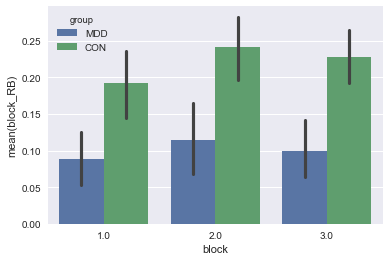

In [30]:
reward_learning_block_plot = sns.barplot(y='block_RB', x = 'block', hue = 'group', data = data, ci = 68, units = 'subject')
%Rpush data
%R resp_bias_block_anova <- aov_ez("subject", dv = "block_RB", data = data,between="group",within = "block", anova_table=list(correction="none", es = "none"))
%R print (resp_bias_block_anova)

The above is pretty much identical to the paper (especially the graph!)

In [31]:
%Rpush data
%R resp_bias_ancova <- aov_ez("subject", dv = "response_bias", type = 2, data = data,between="group", covariate = 'age', factorize = FALSE, anova_table=list(correction="none", es = "none"))
%R print (resp_bias_ancova)

/Users/mlm2/anaconda/envs/pythonthreefive/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Contrasts set to contr.sum for the following variables: group

  warnings.warn(x, RRuntimeWarning)


Anova Table (Type 2 tests)

Response: response_bias
  Effect    df  MSE      F p.value
1  group 1, 45 0.03 6.44 *     .01
2    age 1, 45 0.03   0.41     .53


The above is also almost identical to the paper.

### Discriminability

"No significant effects emerged, all Fs < 0.54, all
ps > 0.50. Accordingly, controls and MDD subjects found
the task equally difficult." Pizzagalli et. al. 2008

/Users/mlm2/anaconda/envs/pythonthreefive/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Contrasts set to contr.sum for the following variables: group

  warnings.warn(x, RRuntimeWarning)


Anova Table (Type 3 tests)

Response: block_disc
       Effect    df  MSE    F p.value
1       group 1, 46 0.22 0.38     .54
2       block 2, 92 0.03 0.54     .58
3 group:block 2, 92 0.03 0.35     .70


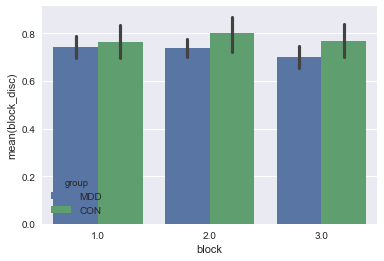

In [32]:
disc_block_plot = sns.barplot(y='block_disc', x = 'block', hue = 'group', data = data, ci = 68, units = 'subject')
%Rpush data
%R disc_block_anova <- aov_ez("subject", dv = "block_disc", data = data,between="group",within = "block", anova_table=list(correction="none", es = "none"))
%R print (disc_block_anova)

You can kind of see the trend that we found with the embarc data

In [33]:
%Rpush data
%R disc_ancova <- aov_ez("subject", dv = "discriminability", type = 2, data = data,between="group", covariate = 'age', factorize = FALSE, anova_table=list(correction="none", es = "none"))
%R print (disc_ancova)

/Users/mlm2/anaconda/envs/pythonthreefive/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Contrasts set to contr.sum for the following variables: group

  warnings.warn(x, RRuntimeWarning)


Anova Table (Type 2 tests)

Response: discriminability
  Effect    df  MSE      F p.value
1  group 1, 45 0.07   0.00     .95
2    age 1, 45 0.07 5.00 *     .03


### Reaction Time

In [48]:
data['time'] = pd.to_numeric(data.time)
data['correct'] = pd.to_numeric(data.correct)

In [35]:
data.groupby('block').time.mean()

block
1.0    632.183404
2.0    583.631568
3.0    577.663559
Name: time, dtype: float64

Compare to reported means of 634.9, 583.97, 577.65. I'll look into the differences more, but they're pretty small so it seems like we're on the right track.  
  
I checked into it more, and it is definitely a very small (rounding?) difference when getting each subject's mean. For example, we have sub 114's long rt to be 430.946667, whereas they have it to be 430.946655. It doesn't stand out as immediately being a rounding difference bc they go out to the same digit. I calculated a few means in excel with the raw data, and they agree with ours. Other than that I don't really know what's causing the difference, but it's so small and not at the trial level so I think it's fine for the DDM. 

Update on the update: when I break it down into block/length it becomes apparent that it is a rounding thing (487.299988 vs 487.300000). I'm not going to worry about it further.

/Users/mlm2/anaconda/envs/pythonthreefive/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Contrasts set to contr.sum for the following variables: group

  warnings.warn(x, RRuntimeWarning)


Anova Table (Type 3 tests)

Response: time
                 Effect    df       MSE         F p.value
1                 group 1, 46 196263.58   7.31 **    .010
2                 block 2, 92   7968.59 12.26 ***  <.0001
3           group:block 2, 92   7968.59      2.08     .13
4             rich_lean 1, 46   4138.95 27.61 ***  <.0001
5       group:rich_lean 1, 46   4138.95      0.00     .96
6       block:rich_lean 2, 92   1722.17    2.96 +     .06
7 group:block:rich_lean 2, 92   1722.17      0.31     .73


/Users/mlm2/anaconda/envs/pythonthreefive/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: NOTE: Results may be misleading due to involvement in interactions

  warnings.warn(x, RRuntimeWarning)


 group   lsmean       SE df lower.CL upper.CL
 CON   528.1791 36.93409 46 453.8346 602.5235
 MDD   669.4999 36.93409 46 595.1554 743.8443

Results are averaged over the levels of: block, rich_lean 
Confidence level used: 0.95 


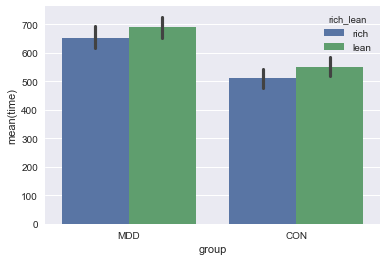

In [36]:
rt_group_plot = sns.barplot(y='time', x = 'group', hue = 'rich_lean', data = data, ci = 68, units = 'subject')
%Rpush data
%R rt_anova <- aov_ez("subject", dv = "time", data = data,within = c("block","rich_lean"), between="group",anova_table=list(correction="none", es = "none"))
%R print (rt_anova)
%R k <- lsmeans(rt_anova, ~group)
%R print(k)

Alexis suggested looking at the estimated marginal means that an anova would output, instead of from descriptive stuff, as that is what might have been reported. From the two cells above it doesn't seem like that's the case either. :(

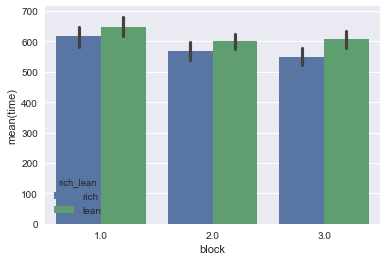

In [38]:
rt_plot = sns.barplot(y='time', x = 'block', hue = 'rich_lean', data = data, ci = 68, units = 'subject')

In [39]:
data.groupby('group').time.mean()

group
CON    530.448869
MDD    671.097993
Name: time, dtype: float64

In [40]:
data.groupby(['sex','group']).time.mean()

sex  group
f    CON      496.549074
     MDD      674.872629
m    CON      556.959932
     MDD      668.184100
Name: time, dtype: float64

Compare to 541.55 for controls and 676.48 reported in the paper. This is pretty different. I went back and added in their summary data for reaction time (avT1_4, so not from the trial data and using their rounding) and it looks almost identical to what we got for the trial stuff, so I don't really know where the other numbers are coming from. It's also frustrating because our F, p, and df are exactly the same, so we must be using the same data?

I went through all of the excel files in the Analysis folder and none of them contain the numbers in the paper, they are probably in the spss .spo files, but I can't open them bc they're from such an old version of spps (now they have .spv files). There is a legacy viewer but you can only use it on a pc. 

In [41]:
con_grouped = data.loc[data['group'] == 'CON']
con_grouped = con_grouped.groupby(['subject','block','rich_lean']).time.mean().mean()
con_grouped

531.12326666547801

In [42]:
mdd_grouped = data.loc[data['group'] == 'MDD']
mdd_grouped = mdd_grouped.groupby(['subject','block','rich_lean']).time.mean().mean()
mdd_grouped

672.44404600947223

Hmm, it doesn't seem like averaging over subject, block and stim gives us the times that they got. 

In [43]:
data.groupby(['group','block', 'rich_lean']).time.mean() 

group  block  rich_lean
CON    1.0    lean         569.019656
              rich         533.740861
       2.0    lean         535.281427
              rich         503.235008
       3.0    lean         548.661777
              rich         493.366209
MDD    1.0    lean         734.173759
              rich         706.523214
       2.0    lean         670.199473
              rich         636.815697
       3.0    lean         668.909894
              rich         610.199288
Name: time, dtype: float64

In [44]:
data.subject.unique()

array(['039', '041', '061', '062', '064', '065', '066', '067', '068',
       '069', '070', '071', '072', '073', '074', '075', '076', '077',
       '078', '079', '092', '094', '097', '098', '100', '104', '106',
       '108', '109', '111', '112', '113', '114', '115', '116', '118',
       '046', '047', '049', '050', '051', '052', '054', '055', '056',
       '057', '058', '059'], dtype=object)

In [45]:
# these weren't read in as numbers
data.avT1_4 = data.avT1_4.apply(lambda x: float(x.replace(',','')))

In [46]:
data.groupby('group').avT1_4.mean()

group
CON    530.448871
MDD    671.097995
Name: avT1_4, dtype: float64

### Hit rates

"...the main effect of *Stimulus Type* was significant, F = 2.39, df = 1,46, p<.001, due to significantly higher hit rates for the rich stimulus (0.88 _+_ 0.06) than lean stimulus (0.77 __+__ 0.12)...this effect was qualified by a significant *Group* X *Stimulus Type* interaction, F = 4.70, df = 1,46, p<0.035...although the two groups did not differ in rich miss rates, MDD subjects showed a trend for *lower* lean miss rates compared to control subjects (0.20 _+_ 0.10 vs 0.25 _+_ 0.10; p = 0.059). As a result, relative to control subjects, MDD subjects were characterized by a significantly smaller differentiation between the two stimuli (overall rich - overal lean hit rate: 0.07 _+_ .010 vs 0.14 _+_ 0.11, t = -2.17, df = 46, p<0.035)"

In [54]:
%Rpush data
%R hit_anova <- aov_ez("subject", dv = "correct", data = data,within = c("rich_lean","block"), between="group",anova_table=list(correction="none", es = "none"))
%R print (hit_anova)

%R hit_means <- lsmeans(hit_anova, ~group*rich_lean)
%R print(hit_means)


/Users/mlm2/anaconda/envs/pythonthreefive/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Contrasts set to contr.sum for the following variables: group

  warnings.warn(x, RRuntimeWarning)


Anova Table (Type 3 tests)

Response: correct
                 Effect    df  MSE         F p.value
1                 group 1, 46 0.04      0.16     .69
2             rich_lean 1, 46 0.02 42.39 ***  <.0001
3       group:rich_lean 1, 46 0.02    4.70 *     .04
4                 block 2, 92 0.00      0.18     .83
5           group:block 2, 92 0.00      0.64     .53
6       rich_lean:block 2, 92 0.00      1.37     .26
7 group:rich_lean:block 2, 92 0.00      0.21     .81


/Users/mlm2/anaconda/envs/pythonthreefive/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: NOTE: Results may be misleading due to involvement in interactions

  warnings.warn(x, RRuntimeWarning)


 group rich_lean    lsmean         SE    df  lower.CL  upper.CL
 CON   lean      0.7497321 0.01950717 81.09 0.7109196 0.7885446
 MDD   lean      0.7931279 0.01977389 82.96 0.7537981 0.8324576
 CON   rich      0.8873613 0.01950717 81.09 0.8485488 0.9261738
 MDD   rich      0.8619701 0.01977389 82.96 0.8226404 0.9012999

Results are averaged over the levels of: block 
Confidence level used: 0.95 


## DDM

In [3]:
#ddm_data = data.rename(index = str, columns = {'subject' : 'subj_idx', 'correct': 'response', 'time': 'rt'})
#ddm_data.to_csv('sigdep_ddm_data_acc_coded.csv')
ddm_data = hddm.load_csv('sigdep_ddm_data_acc_coded.csv')
ddm_data['rt'] = ddm_data['rt'] / 1000 # convert to seconds

In [4]:
ddm_data.head()

,Unnamed: 0,subj_idx,date,bias,short_key,long_key,trial,length,rt,key_press,...,avlnT1_4,avshT1_4,avlgT1_4,excluded,Group#,Group,block,block_RB,block_disc,rich_lean
0,0,39,6/15/2004,short,/,z,1,short,0.499,/,...,734.02002,653.275146,734.02002,0,0,MDD,1.0,0.257556,0.577891,rich
1,1,39,6/15/2004,short,/,z,2,long,0.628,z,...,734.02002,653.275146,734.02002,0,0,MDD,1.0,0.257556,0.577891,lean
2,2,39,6/15/2004,short,/,z,3,short,0.705,/,...,734.02002,653.275146,734.02002,0,0,MDD,1.0,0.257556,0.577891,rich
3,3,39,6/15/2004,short,/,z,4,long,0.588,z,...,734.02002,653.275146,734.02002,0,0,MDD,1.0,0.257556,0.577891,lean
4,4,39,6/15/2004,short,/,z,5,short,0.667,z,...,734.02002,653.275146,734.02002,0,0,MDD,1.0,0.257556,0.577891,rich


### Basic model that is accuracy coded and doesn't know anything about lean/rich trials, not super informative

In [19]:
sigdep_acc_group = hddm.HDDM(ddm_data, depends_on={'v': 'group', 'a': 'group', 't':'group'})
sigdep_acc_group.find_starting_values()
sigdep_acc_group.sample(10000, burn=1000, dbname='sigdep_acc_group.db', db='pickle')
sigdep_acc_group.save('sigdep_acc_group')

 [-----------------100%-----------------] 10000 of 10000 complete in 703.3 sec

P_v(MDD > CON) =  0.0378888888889
P_v(CON > MDD) =  0.962111111111


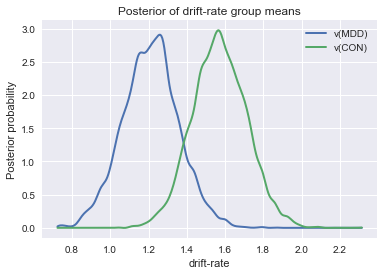

In [20]:
v_MDD, v_CON = sigdep_acc_group.nodes_db.node[['v(MDD)','v(CON)']]
hddm.analyze.plot_posterior_nodes([v_MDD, v_CON])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')

print ("P_v(MDD > CON) = ", (v_MDD.trace() > v_CON.trace()).mean())
print ("P_v(CON > MDD) = ", (v_CON.trace() > v_MDD.trace()).mean())

P_a(MDD > CON) =  0.999111111111
P_a(CON > MDD) =  0.000888888888889


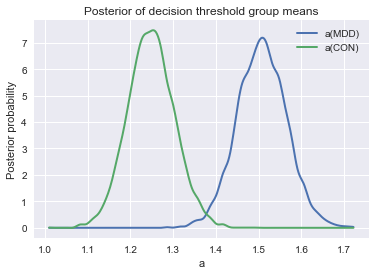

In [21]:
a_MDD, a_CON = sigdep_acc_group.nodes_db.node[['a(MDD)','a(CON)']]
hddm.analyze.plot_posterior_nodes([a_MDD, a_CON])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of decision threshold group means')

print ("P_a(MDD > CON) = ", (a_MDD.trace() > a_CON.trace()).mean())
print ("P_a(CON > MDD) = ", (a_CON.trace() > a_MDD.trace()).mean())

P_t(MDD > CON) =  0.398333333333
P_t(CON > MDD) =  0.601666666667


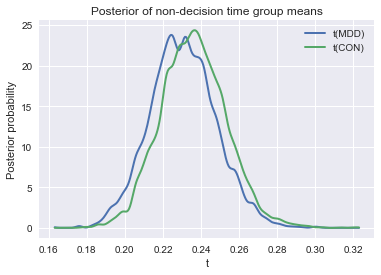

In [22]:
t_MDD, t_CON = sigdep_acc_group.nodes_db.node[['t(MDD)','t(CON)']]
hddm.analyze.plot_posterior_nodes([t_MDD, t_CON])
plt.xlabel('t')
plt.ylabel('Posterior probability')
plt.title('Posterior of non-decision time group means')

print ("P_t(MDD > CON) = ", (t_MDD.trace() > t_CON.trace()).mean())
print ("P_t(CON > MDD) = ", (t_CON.trace() > t_MDD.trace()).mean())

In [23]:
sigdep_acc_group.dic

4265.0453902958125

In [24]:
sigdep_acc_group.dic_info

{'DIC': 4265.0453902958125,
 'deviance': 4126.2282027113179,
 'pD': 138.8171875844946}

It's cool that at least so far we're seeing the same things as with the EMBARC data here. 

So far all of the models we've run have been accuracy coded. To look at the starting point bias, we need to code by response, so did they select the rich or lean stim?

In [10]:
# creating a dataframe that is response coded, meaning the 'response' column corresponds to the selection of a rich or
# lean stim, rather than a correct or incorrect response. We feed in the 'stim' column that tells the model which was 
# actually the correct response (rich or lean)

ddm_data_resp = ddm_data
ddm_data_resp['rich_key'] = np.nan
ddm_data_resp.loc[ddm_data_resp['bias'] == 'short', 'rich_key'] = ddm_data_resp['short_key']
ddm_data_resp.loc[ddm_data_resp['bias'] == 'long', 'rich_key'] = ddm_data_resp['long_key']
ddm_data_resp['stim'] = 0
ddm_data_resp.loc[ddm_data_resp['rich_lean'] == 'rich', 'stim'] = 1
ddm_data_resp.loc[ddm_data_resp['rich_lean'] == 'lean', 'stim'] = 0
ddm_data_resp = ddm_data_resp.rename(index = str, columns={'response': 'correct'})
ddm_data_resp['response'] = 0
ddm_data_resp.loc[ddm_data_resp['key_press'] == ddm_data_resp['rich_key'], 'response'] = 1

In [248]:
ddm_data_resp.head(10) # looks right, save it
ddm_data_resp.to_csv('sigdep_ddm_data_resp_coded.csv')

In [11]:
ddm_data_resp = hddm.load_csv('sigdep_ddm_data_resp_coded.csv') # load it with hddm (is this actually needed or can we just use the df?)

### Same basic model as before, but instead of accuracy coded it is response coded

In [15]:
sigdep_stim_group = hddm.HDDM(ddm_data_resp, depends_on={'v': 'group', 'a': 'group', 't':'group'})
sigdep_stim_group.find_starting_values()
sigdep_stim_group.sample(10000, burn=1000, dbname='sigdep_stim_group.db', db='pickle')
sigdep_stim_group.save('sigdep_stim_group')

 [-----------------100%-----------------] 10000 of 10000 complete in 711.7 sec

P_v(MDD > CON) =  0.00355555555556
P_v(CON > MDD) =  0.996444444444


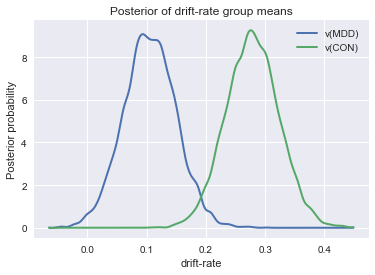

In [16]:
v_MDD, v_CON = sigdep_stim_group.nodes_db.node[['v(MDD)','v(CON)']]
hddm.analyze.plot_posterior_nodes([v_MDD, v_CON])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')

print ("P_v(MDD > CON) = ", (v_MDD.trace() > v_CON.trace()).mean())
print ("P_v(CON > MDD) = ", (v_CON.trace() > v_MDD.trace()).mean())

P_a(MDD > CON) =  0.999555555556
P_a(CON > MDD) =  0.000444444444444


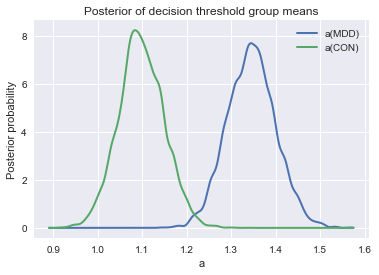

In [17]:
a_MDD, a_CON = sigdep_stim_group.nodes_db.node[['a(MDD)','a(CON)']]
hddm.analyze.plot_posterior_nodes([a_MDD, a_CON])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of decision threshold group means')

print ("P_a(MDD > CON) = ", (a_MDD.trace() > a_CON.trace()).mean())
print ("P_a(CON > MDD) = ", (a_CON.trace() > a_MDD.trace()).mean())

P_t(MDD > CON) =  0.46
P_t(CON > MDD) =  0.54


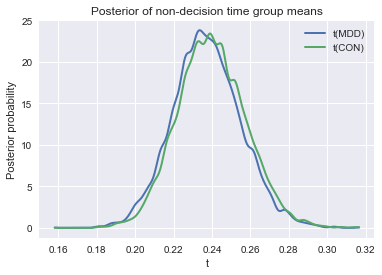

In [122]:
t_MDD, t_CON = sigdep_stim_group.nodes_db.node[['t(MDD)','t(CON)']]
hddm.analyze.plot_posterior_nodes([t_MDD, t_CON])
plt.xlabel('t')
plt.ylabel('Posterior probability')
plt.title('Posterior of non-decision time group means')

print ("P_t(MDD > CON) = ", (t_MDD.trace() > t_CON.trace()).mean())
print ("P_t(CON > MDD) = ", (t_CON.trace() > t_MDD.trace()).mean())

In [18]:
sigdep_stim_group.dic_info

{'DIC': 11549.796898170807,
 'deviance': 11420.171804430822,
 'pD': 129.62509373998546}

### I'm running the correlations on this model (for now) b/c it's the simplest one that has info on rich/lean

In [185]:
all_stats = m_resp.gen_stats()
all_stats.to_csv('all_stats.csv')
all_stats.head()

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a(CON),1.10054,0.0500895,1.00682,1.06684,1.10025,1.13331,1.2028,0.00062827
a(MDD),1.34192,0.0545901,1.23658,1.3055,1.34173,1.37785,1.45018,0.000605204
a_std,0.256894,0.029037,0.207736,0.236344,0.254128,0.274841,0.321068,0.000384164
a_subj(CON).61,0.967161,0.0253346,0.918649,0.949956,0.966693,0.983736,1.01783,0.000315567
a_subj(CON).62,1.18754,0.0315697,1.12777,1.16561,1.18729,1.20877,1.25107,0.000422646


In excel I just took the v for mdds, it's hard to do in the notebook b/c there is no column for group, prob possible with regex so I'll go back and fix if anything interesting comes out of it.


	Pearson's product-moment correlation

data:  mdd_v_stats_dropped$MASQ_AD and mdd_v_stats_dropped$mean
t = -1.336, df = 21, p-value = 0.1959
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.6204999  0.1495743
sample estimates:
       cor 
-0.2798841 



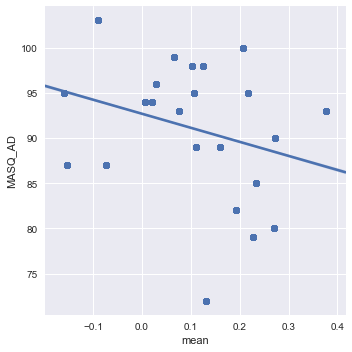

In [235]:
mdd_v_stats = pd.read_csv('mdd_v_stats.csv')
mdd_v_stats = mdd_v_stats.rename(index = str, columns = {'Unnamed: 0' : 'subj_idx'})
mdd_data = ddm_data.loc[ddm_data.group == 'MDD']
mdd_v_stats = mdd_v_stats.merge(mdd_data, how = 'outer')
mdd_v_stats_dropped = mdd_v_stats.drop_duplicates('subj_idx') # drop duplicates for the correlation
drift_rate_ad = sns.lmplot(y='MASQ_AD', x = 'mean', data=mdd_v_stats,ci=68)

%Rpush mdd_v_stats_dropped
%R drift_rate_ad <- cor.test(mdd_v_stats_dropped$MASQ_AD,mdd_v_stats_dropped$mean,method="pearson")
%R print (drift_rate_ad) 

No significant correlation but this is in the direction that we'd expect.

In [244]:
# partialing out age doesn't change it much (if I did it right)
%Rpush mdd_v_stats_dropped
%R drift_rate_ad <- pcor.test(mdd_v_stats_dropped$MASQ_AD,mdd_v_stats_dropped$mean,mdd_v_stats_dropped$age,method="pearson")
%R print (drift_rate_ad) 

    estimate   p.value statistic  n gp  Method
1 -0.2710441 0.2224266 -1.259285 23  1 pearson



	Pearson's product-moment correlation

data:  mdd_a_stats_dropped$MASQ_AD and mdd_a_stats_dropped$mean
t = -1.3636, df = 21, p-value = 0.1871
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.6240384  0.1439242
sample estimates:
       cor 
-0.2851976 



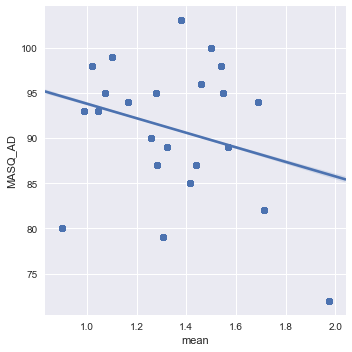

In [232]:
#threshold
mdd_a_stats = pd.read_csv('mdd_a_stats.csv')
mdd_a_stats = mdd_a_stats.rename(index = str, columns = {'Unnamed: 0' : 'subj_idx'})
mdd_data = ddm_data.loc[ddm_data.group == 'MDD']
mdd_a_stats = mdd_a_stats.merge(mdd_data, how = 'outer')
mdd_a_stats_dropped = mdd_a_stats.drop_duplicates('subj_idx') # drop duplicates for the correlation
threshold_ad = sns.lmplot(y='MASQ_AD', x = 'mean', data=mdd_a_stats,ci=68)

%Rpush mdd_a_stats_dropped
%R threshold_ad <- cor.test(mdd_a_stats_dropped$MASQ_AD,mdd_a_stats_dropped$mean,method="pearson")
%R print (threshold_ad) 

In [245]:
# partialing out age doesn't change it much (if I did it right)
%Rpush mdd_a_stats_dropped
%R threshold_ad <- pcor.test(mdd_a_stats_dropped$MASQ_AD,mdd_a_stats_dropped$mean,mdd_a_stats_dropped$age,method="pearson")
%R print (threshold_ad) 

    estimate   p.value statistic  n gp  Method
1 -0.2952091 0.1822749 -1.381798 23  1 pearson


Opposite of what we'd expect for threshold

Now that I'm starting to look at DIC values, it might make more sense to run the correlations on the accuracy coded model. For power we could also include the CTLs...

In [59]:
def get_param(item):
    '''Returns the paramerter from the genstats() data'''
    if len(item) == 14:
        param = item[0]
    else:
        param = np.nan
    return(param)

In [60]:
def get_group(item):
    '''Returns the group info from the genstats() data'''
    if len(item) == 14:
        group = item[7:10]
    else:
        group = np.nan
    return(group)

In [61]:
def get_id(item):
    '''Returns the id info from the genstats() data'''
    if len(item) == 14:
        sub_id = item[12:18]
    else:
        sub_id = np.nan
    return(sub_id)

In [ ]:
mdd_acc_rl_within.gen_stats_stats_stats()

In [62]:
acc_group_stats = sigdep_acc_group.gen_stats()
acc_group_stats.to_csv('acc_group_stats.csv')
acc_group_stats = pd.read_csv('acc_group_stats.csv')
acc_group_stats.rename(columns={'Unnamed: 0': 'to_extract'}, inplace=True)
acc_group_stats.head()

,to_extract,mean,std,2.5q,25q,50q,75q,97.5q,mc err
0,a(CON),1.250488,0.053686,1.147406,1.214451,1.249888,1.285384,1.358228,0.000661
1,a(MDD),1.504473,0.057204,1.391886,1.465806,1.504255,1.542863,1.618287,0.000629
2,a_std,0.271445,0.031388,0.216926,0.249816,0.268999,0.289804,0.341462,0.000445
3,a_subj(CON).61,1.322874,0.054345,1.220600,1.285625,1.321742,1.358202,1.433706,0.001093
4,a_subj(CON).62,1.305860,0.039235,1.232352,1.278915,1.304626,1.332270,1.384700,0.000550


In [63]:
# get column info and merge this with the clinical data
acc_group_stats = acc_group_stats[['to_extract', 'mean']]
acc_group_stats['param'] = acc_group_stats.to_extract.apply(get_param)
acc_group_stats['group'] = acc_group_stats.to_extract.apply(get_group)
acc_group_stats['subject'] = acc_group_stats.to_extract.apply(get_id)
acc_group_stats.subject = acc_group_stats.subject.astype(str).apply(lambda x: x.zfill(3))
acc_group_stats = pd.merge(acc_group_stats, groups, on='subject')
acc_group_stats.head(10)

,to_extract,mean,param,group_x,subject,exclude,group_y,age,sex,BDItotal,...,avT1_3,avrhT1_3,avlnT1_3,avshT1_3,avlgT1_3,MASQ_AD,avrhT1_4,avlnT1_4,avshT1_4,avlgT1_4
0,a_subj(CON).61,1.322874,a,CON,061,0.0,CON,27,f,4,...,454.399994,426.600006,485.288879,485.288879,426.600006,40.0,435.516785,483.65277,483.652771,435.51679
1,v_subj(CON).61,2.665074,v,CON,061,0.0,CON,27,f,4,...,454.399994,426.600006,485.288879,485.288879,426.600006,40.0,435.516785,483.65277,483.652771,435.51679
2,t_subj(CON).61,0.239561,t,CON,061,0.0,CON,27,f,4,...,454.399994,426.600006,485.288879,485.288879,426.600006,40.0,435.516785,483.65277,483.652771,435.51679
3,a_subj(CON).62,1.305860,a,CON,062,0.0,CON,45,f,1,...,967.670105,919.645813,"1,014.714294","1,014.714294",919.645813,53.0,943.952698,"1,025.62158","1,025.621582",943.95270
4,v_subj(CON).62,1.285597,v,CON,062,0.0,CON,45,f,1,...,967.670105,919.645813,"1,014.714294","1,014.714294",919.645813,53.0,943.952698,"1,025.62158","1,025.621582",943.95270
5,t_subj(CON).62,0.650336,t,CON,062,0.0,CON,45,f,1,...,967.670105,919.645813,"1,014.714294","1,014.714294",919.645813,53.0,943.952698,"1,025.62158","1,025.621582",943.95270
6,a_subj(CON).66,1.089924,a,CON,066,0.0,CON,47,m,0,...,359.369995,348.019989,370.720001,370.720001,348.019989,46.0,357.255035,379.12082,379.120819,357.25504
7,v_subj(CON).66,2.143912,v,CON,066,0.0,CON,47,m,0,...,359.369995,348.019989,370.720001,370.720001,348.019989,46.0,357.255035,379.12082,379.120819,357.25504
8,t_subj(CON).66,0.186007,t,CON,066,0.0,CON,47,m,0,...,359.369995,348.019989,370.720001,370.720001,348.019989,46.0,357.255035,379.12082,379.120819,357.25504
9,a_subj(CON).67,1.252196,a,CON,067,0.0,CON,50,f,10,...,480.640015,450.359985,510.920013,450.359985,510.920013,61.0,495.939178,551.65997,495.939178,551.65997



	Pearson's product-moment correlation

data:  acc_group_stats_param$mean and acc_group_stats_param$MASQ_AD
t = -0.90478, df = 34, p-value = 0.3719
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4587593  0.1844960
sample estimates:
       cor 
-0.1533339 




	Pearson's product-moment correlation

data:  acc_group_stats_param$mean and acc_group_stats_param$MASQ_AD
t = 2.1837, df = 34, p-value = 0.03598
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.02507086 0.60907404
sample estimates:
      cor 
0.3507178 




	Pearson's product-moment correlation

data:  acc_group_stats_param$mean and acc_group_stats_param$MASQ_AD
t = -0.3754, df = 34, p-value = 0.7097
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3846636  0.2699873
sample estimates:
        cor 
-0.06424716 



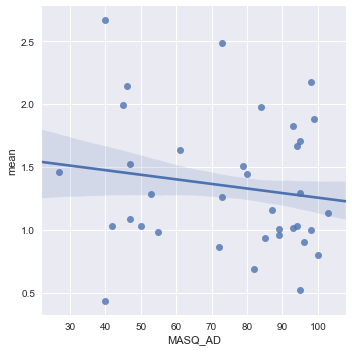

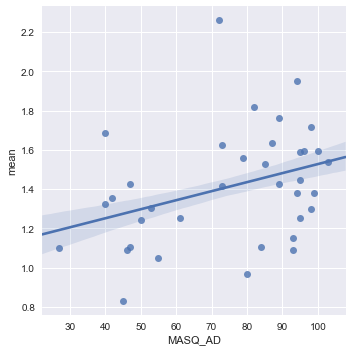

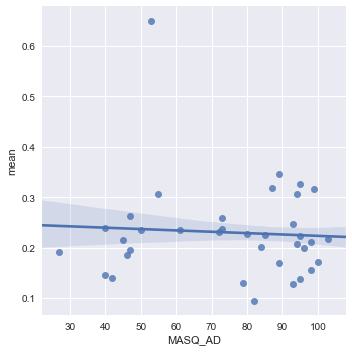

In [64]:
# for ALL subjects, are there any correlations with anhedonia and a parameter?
# Yes, a higher decision threshold is correlated with greater anhedonia

params = ['v','a','t']
for param in params:
    acc_group_stats_param = acc_group_stats[acc_group_stats['param'] == param]
    corr_param = sns.lmplot(y='mean', x = 'MASQ_AD', data=acc_group_stats_param,ci=68)

    %Rpush acc_group_stats_param
    %R corr_param <- cor.test(acc_group_stats_param$mean,acc_group_stats_param$MASQ_AD,method="pearson")
    %R print (corr_param)



	Pearson's product-moment correlation

data:  acc_group_stats_param$mean and acc_group_stats_param$MASQ_AD
t = 0.87567, df = 19, p-value = 0.3921
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2565419  0.5793825
sample estimates:
     cor 
0.196957 




	Pearson's product-moment correlation

data:  acc_group_stats_param$mean and acc_group_stats_param$MASQ_AD
t = -1.3469, df = 19, p-value = 0.1939
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.6447462  0.1563875
sample estimates:
       cor 
-0.2952304 




	Pearson's product-moment correlation

data:  acc_group_stats_param$mean and acc_group_stats_param$MASQ_AD
t = 0.4762, df = 19, p-value = 0.6394
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3389762  0.5160937
sample estimates:
      cor 
0.1086025 



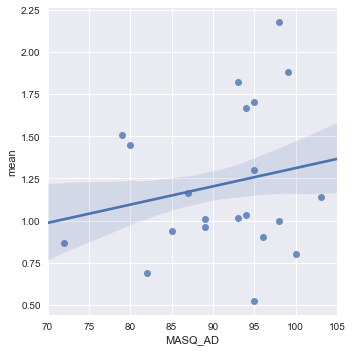

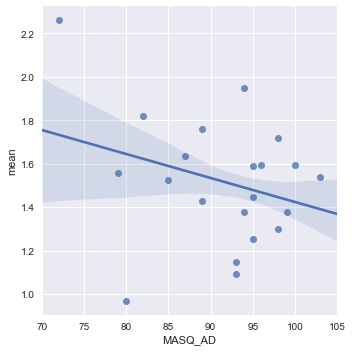

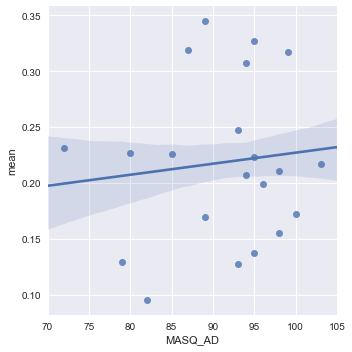

In [66]:
# What if we just look in the MDDS?
# The threshold finding becomes nonsignificant

params = ['v','a','t']
for param in params:
    acc_group_stats_param = acc_group_stats[acc_group_stats['param'] == param]
    acc_group_stats_param = acc_group_stats_param[acc_group_stats_param['group_x'] == 'MDD']
    corr_param = sns.lmplot(y='mean', x = 'MASQ_AD', data=acc_group_stats_param,ci=68)

    %Rpush acc_group_stats_param
    %R corr_param <- cor.test(acc_group_stats_param$mean,acc_group_stats_param$MASQ_AD,method="pearson")
    %R print (corr_param)


### Model that uses HDDMStimCoding to see if there is a starting point bias difference between the two groups

In [68]:
sigdep_stim_group_bias = hddm.HDDMStimCoding(ddm_data_resp, include='z', stim_col='stim', split_param='z', depends_on={'v': 'group', 'a': 'group', 'z': 'group'})
sigdep_stim_group_bias.find_starting_values()
sigdep_stim_group_bias.sample(10000, burn=1000, dbname='sigdep_stim_group_bias.db', db='pickle')
sigdep_stim_group_bias.save('sigdep_stim_group_bias')



Setting model to be non-informative
Adding z to includes.
 [-----------------100%-----------------] 10000 of 10000 complete in 2287.6 sec

P_z(MDD > CON) =  0.214555555556
P_z(CON > MDD) =  0.785444444444


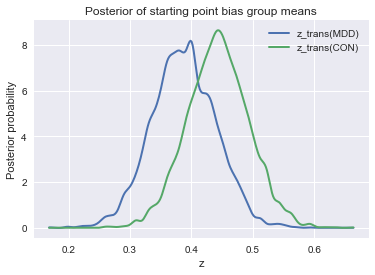

In [71]:
z_MDD, z_CON = sigdep_stim_group_bias.nodes_db.node[['z_trans(MDD)','z_trans(CON)']]
hddm.analyze.plot_posterior_nodes([z_MDD, z_CON])
plt.xlabel('z')
plt.ylabel('Posterior probability')
plt.title('Posterior of starting point bias group means')

print ("P_z(MDD > CON) = ", (z_MDD.trace() > z_CON.trace()).mean())
print ("P_z(CON > MDD) = ", (z_CON.trace() > z_MDD.trace()).mean())

P_v(MDD > CON) =  0.00344444444444
P_v(CON > MDD) =  0.996555555556


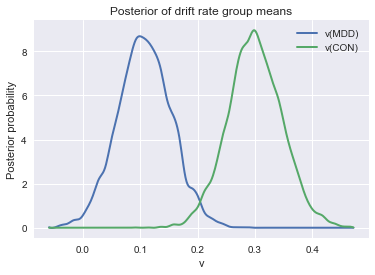

In [72]:
v_MDD, v_CON = sigdep_stim_group_bias.nodes_db.node[['v(MDD)','v(CON)']]
hddm.analyze.plot_posterior_nodes([v_MDD, v_CON])
plt.xlabel('v')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate group means')

print ("P_v(MDD > CON) = ", (v_MDD.trace() > v_CON.trace()).mean())
print ("P_v(CON > MDD) = ", (v_CON.trace() > v_MDD.trace()).mean())

P_a(MDD > CON) =  0.999555555556
P_a(CON > MDD) =  0.000444444444444


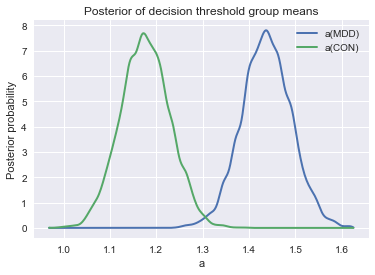

In [73]:
a_MDD, a_CON = sigdep_stim_group_bias.nodes_db.node[['a(MDD)','a(CON)']]
hddm.analyze.plot_posterior_nodes([a_MDD, a_CON])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of decision threshold group means')

print ("P_a(MDD > CON) = ", (a_MDD.trace() > a_CON.trace()).mean())
print ("P_a(CON > MDD) = ", (a_CON.trace() > a_MDD.trace()).mean())

In [74]:
sigdep_stim_group_bias.dic_info

{'DIC': 9826.8898079502815,
 'deviance': 9652.8316793961912,
 'pD': 174.05812855409022}

Not sure if we want to split by z or v, so I ran both. They don't look very different.

In [255]:
model_v = hddm.HDDMStimCoding(ddm_data, include='z', stim_col='stim', split_param='v', depends_on={'v': 'group', 'a': 'group', 't':'group', 'z': 'group'})
model_v.find_starting_values()
model_v.sample(5000, burn=500)

 [-----------------100%-----------------] 5000 of 5000 complete in 553.7 sec

P_z(MDD > CON) =  0.163555555556
P_z(CON > MDD) =  0.836444444444


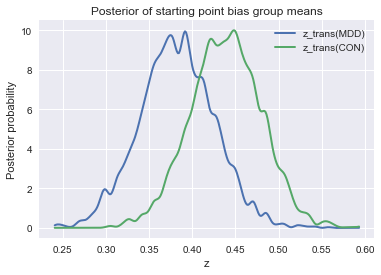

In [256]:
z_MDD, z_CON = model_v.nodes_db.node[['z_trans(MDD)','z_trans(CON)']]
hddm.analyze.plot_posterior_nodes([z_MDD, z_CON])
plt.xlabel('z')
plt.ylabel('Posterior probability')
plt.title('Posterior of starting point bias group means')
plt.savefig('ctl_mdd_a_more_samples.pdf')

print ("P_z(MDD > CON) = ", (z_MDD.trace() > z_CON.trace()).mean())
print ("P_z(CON > MDD) = ", (z_CON.trace() > z_MDD.trace()).mean())

Not really sure what to make of this but it seems like there isn't a starting point difference in groups in either model. So maybe the reason that the ctls are more likely to choose the rich stim is that they have quicker drift rates and/or lower thresholds on those trials. If that's the case, we should do a within subjects model for rich/lean stim, and see if the drift rates/thresholds for each vary by group (I think).

### Separate Accuracy-coded models for MDDs/CTLs with rich/lean stim types as within factor

In [76]:
ddm_data = hddm.load_csv('sigdep_ddm_data_acc_coded.csv')
ddm_data['rt'] = ddm_data['rt'] / 1000 # convert to seconds
mdd_data = ddm_data.loc[ddm_data.group == 'MDD']
mdd_acc_rl_within = hddm.HDDMRegressor(mdd_data, ['v ~ 0 + C(rich_lean)', 'a ~ 0 + C(rich_lean)'])
mdd_acc_rl_within.sample(10000, burn=1000, dbname='mdd_acc_rl_within.db', db='pickle')
mdd_acc_rl_within.save('mdd_acc_rl_within')

Adding these covariates:
['v_C(rich_lean)[lean]', 'v_C(rich_lean)[rich]']
Adding these covariates:
['a_C(rich_lean)[lean]', 'a_C(rich_lean)[rich]']
 [-----------------100%-----------------] 10001 of 10000 complete in 9394.2 secWARNING: Will not save custom link functions.


In [115]:
mdd_acc_rl_within.dic_info

{'DIC': 5021.191305140238,
 'deviance': 4912.1159504877223,
 'pD': 109.07535465251567}

In [258]:
ctl_data = ddm_data.loc[ddm_data.group == 'CON']
ctl_acc_rl_within = hddm.HDDMRegressor(ctl_data, ['v ~ 0 + C(rich_lean)', 'a ~ 0 + C(rich_lean)'])
ctl_acc_rl_within.sample(10000, burn=1000, dbname = 'ctl_acc_rl_within.db', db = 'pickle')
ctl_acc_rl_within.save('ctl_acc_rl_within')

Adding these covariates:
['v_C(rich_lean)[lean]', 'v_C(rich_lean)[rich]']
Adding these covariates:
['a_C(rich_lean)[lean]', 'a_C(rich_lean)[rich]']
 [-----------------100%-----------------] 1001 of 1000 complete in 1119.9 sec

,knode_name,stochastic,observed,subj,node,tag,depends,hidden,Unnamed: 0,subj_idx,...,block_disc,rich_lean,mean,std,2.5q,25q,50q,75q,97.5q,mc err
t,t,True,False,False,t,(),[],False,NaN,NaN,...,NaN,NaN,0.24038,0.0194348,0.206347,0.227221,0.239751,0.251819,0.279817,0.000784921
t_std,t_std,True,False,False,t_std,(),[],False,NaN,NaN,...,NaN,NaN,0.0974374,0.015561,0.0725216,0.0863132,0.0952832,0.106399,0.133719,0.000644194
v_C(rich_lean)[lean],v_C(rich_lean)[lean],True,False,False,v_C(rich_lean)[lean],(),[],False,NaN,NaN,...,NaN,NaN,1.19407,0.190365,0.819261,1.06594,1.19346,1.31686,1.57818,0.00626564
v_C(rich_lean)[lean]_std,v_C(rich_lean)[lean]_std,True,False,False,v_C(rich_lean)[lean]_std,(),[],False,NaN,NaN,...,NaN,NaN,0.935509,0.160232,0.683732,0.820706,0.910292,1.02587,1.32968,0.00702049
v_C(rich_lean)[rich],v_C(rich_lean)[rich],True,False,False,v_C(rich_lean)[rich],(),[],False,NaN,NaN,...,NaN,NaN,2.12655,0.207964,1.745,1.99254,2.12686,2.26351,2.53375,0.00745931
v_C(rich_lean)[rich]_std,v_C(rich_lean)[rich]_std,True,False,False,v_C(rich_lean)[rich]_std,(),[],False,NaN,NaN,...,NaN,NaN,0.995682,0.16493,0.732241,0.879898,0.978656,1.09395,1.36183,0.00773239
a_C(rich_lean)[lean],a_C(rich_lean)[lean],True,False,False,a_C(rich_lean)[lean],(),[],False,NaN,NaN,...,NaN,NaN,1.25314,0.0569535,1.14803,1.2129,1.24927,1.29165,1.37765,0.00214665
a_C(rich_lean)[lean]_std,a_C(rich_lean)[lean]_std,True,False,False,a_C(rich_lean)[lean]_std,(),[],False,NaN,NaN,...,NaN,NaN,0.267545,0.0457749,0.193293,0.236484,0.261865,0.291184,0.376801,0.00212415
a_C(rich_lean)[rich],a_C(rich_lean)[rich],True,False,False,a_C(rich_lean)[rich],(),[],False,NaN,NaN,...,NaN,NaN,1.29069,0.0543393,1.18897,1.25359,1.28814,1.32415,1.39924,0.00214886
a_C(rich_lean)[rich]_std,a_C(rich_lean)[rich]_std,True,False,False,a_C(rich_lean)[rich]_std,(),[],False,NaN,NaN,...,NaN,NaN,0.249241,0.0417813,0.183374,0.219949,0.243981,0.273525,0.346555,0.00183394


In [ ]:
ctl_acc_rl_within.dic_info

P_v(rich > lean) =  0.0288888888889
P_v(lean > rich) =  0.971111111111


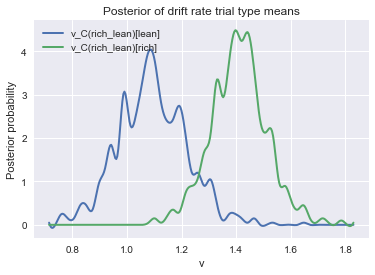

In [259]:
v_lean, v_rich = mdd_within.nodes_db.node[['v_C(rich_lean)[lean]','v_C(rich_lean)[rich]']]
hddm.analyze.plot_posterior_nodes([v_lean, v_rich])
plt.xlabel('v')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate trial type means')

print ("P_v(rich > lean) = ", (v_lean.trace() > v_rich.trace()).mean())
print ("P_v(lean > rich) = ", (v_rich.trace() > v_lean.trace()).mean())

MDDS have faster drift rates for rich stims than lean, is this true for CTLS...

P_v(rich > lean) =  0.0
P_v(lean > rich) =  1.0


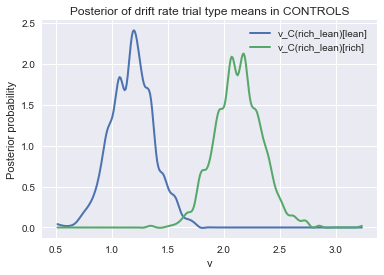

In [260]:
v_lean, v_rich = ctl_within.nodes_db.node[['v_C(rich_lean)[lean]','v_C(rich_lean)[rich]']]
hddm.analyze.plot_posterior_nodes([v_lean, v_rich])
plt.xlabel('v')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate trial type means in CONTROLS')

print ("P_v(rich > lean) = ", (v_lean.trace() > v_rich.trace()).mean())
print ("P_v(lean > rich) = ", (v_rich.trace() > v_lean.trace()).mean())

Yes, CTLs also have faster drift rates for rich stimuli, AND it looks like its greater than in the mdds.  
  
What about threshold?

P_a(rich > lean) =  0.596666666667
P_a(lean > rich) =  0.403333333333


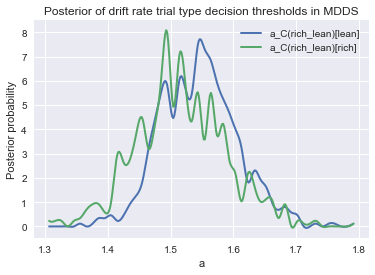

In [261]:
a_lean, a_rich = mdd_within.nodes_db.node[['a_C(rich_lean)[lean]','a_C(rich_lean)[rich]']]
hddm.analyze.plot_posterior_nodes([a_lean, a_rich])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate trial type decision thresholds in MDDS')

print ("P_a(rich > lean) = ", (a_lean.trace() > a_rich.trace()).mean())
print ("P_a(lean > rich) = ", (a_rich.trace() > a_lean.trace()).mean())

P_a(rich > lean) =  0.297777777778
P_a(lean > rich) =  0.702222222222


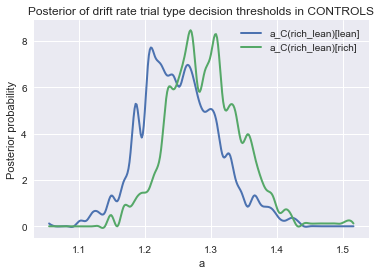

In [262]:
a_lean, a_rich = ctl_within.nodes_db.node[['a_C(rich_lean)[lean]','a_C(rich_lean)[rich]']]
hddm.analyze.plot_posterior_nodes([a_lean, a_rich])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate trial type decision thresholds in CONTROLS')

print ("P_a(rich > lean) = ", (a_lean.trace() > a_rich.trace()).mean())
print ("P_a(lean > rich) = ", (a_rich.trace() > a_lean.trace()).mean())

Seems like this is specific to drift rate, and not threshold

Since it looks like MDDs and controls are the same on lean trials, but differ on drift rate on the rich trials, lets run seperate models for the rich trial and lean trials, and see if they actually do differ. 

In [78]:
# get just the rich trials and just the lean trials

ddm_data = hddm.load_csv('sigdep_ddm_data_acc_coded.csv')
ddm_data['rt'] = ddm_data['rt'] / 1000
rich_data = ddm_data[ddm_data['rich_lean'] == 'rich']
lean_data = ddm_data[ddm_data['rich_lean'] == 'lean']

In [79]:
rich_acc_group = hddm.HDDM(rich_data, depends_on= {'v': 'group', 'a': 'group'})
rich_acc_group.sample(10000, burn=1000, dbname = 'rich_acc_group.db', db='pickle')
rich_acc_group.save('rich_acc_group')

 [-----------------100%-----------------] 10000 of 10000 complete in 495.2 sec

In [80]:
rich_acc_group.dic_info

{'DIC': -260.30339065799728,
 'deviance': -395.51285823588688,
 'pD': 135.2094675778896}

In [81]:
lean_acc_group = hddm.HDDM(lean_data, depends_on = {'v': 'group', 'a': 'group'})
lean_acc_group.sample(10000, burn=1000, dbname = 'lean_acc_group.db', db='pickle')
lean_acc_group.save('lean_acc_group')

 [-----------------100%-----------------] 10001 of 10000 complete in 496.2 sec

In [82]:
lean_acc_group.dic_info

{'DIC': 3475.1959004278851,
 'deviance': 3339.2342450105098,
 'pD': 135.96165541737537}

P_v(MDD > CTL) =  0.00244444444444
P_v(CTL > MDD) =  0.997555555556


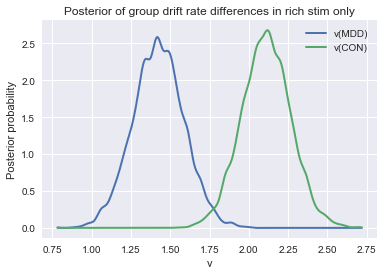

In [86]:
v_MDD_rich, v_CTL_rich = rich_acc_group.nodes_db.node[['v(MDD)','v(CON)']]
hddm.analyze.plot_posterior_nodes([v_MDD_rich, v_CTL_rich])
plt.xlabel('v')
plt.ylabel('Posterior probability')
plt.title('Posterior of group drift rate differences in rich stim only')

print ("P_v(MDD > CTL) = ", (v_MDD_rich.trace() > v_CTL_rich.trace()).mean())
print ("P_v(CTL > MDD) = ", (v_CTL_rich.trace() > v_MDD_rich.trace()).mean())

P_a(MDD > CTL) =  0.992111111111
P_a(CTL > MDD) =  0.00788888888889


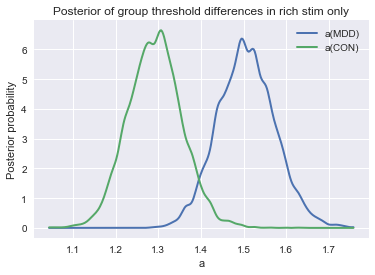

In [87]:
a_MDD_rich, a_CTL_rich = rich_acc_group.nodes_db.node[['a(MDD)','a(CON)']]
hddm.analyze.plot_posterior_nodes([a_MDD_rich, a_CTL_rich])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of group threshold differences in rich stim only')

print ("P_a(MDD > CTL) = ", (a_MDD_rich.trace() > a_CTL_rich.trace()).mean())
print ("P_a(CTL > MDD) = ", (a_CTL_rich.trace() > a_MDD_rich.trace()).mean())

MDDs and controls sig. differ on drift rate and threshold in rich trials, is the true for lean trials too?  
  
Nope! They have similar drift rates on the lean stim. 

P_v(MDD > CTL) =  0.336777777778
P_v(CTL > MDD) =  0.663222222222


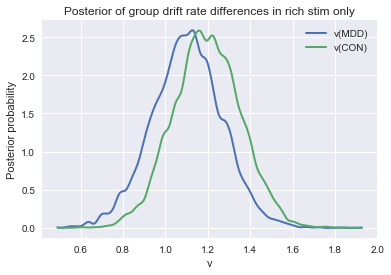

In [90]:
v_MDD_lean, v_CTL_lean = lean_acc_group.nodes_db.node[['v(MDD)','v(CON)']]
hddm.analyze.plot_posterior_nodes([v_MDD_lean, v_CTL_lean])
plt.xlabel('v')
plt.ylabel('Posterior probability')
plt.title('Posterior of group drift rate differences in rich stim only')

print ("P_v(MDD > CTL) = ", (v_MDD_lean.trace() > v_CTL_lean.trace()).mean())
print ("P_v(CTL > MDD) = ", (v_CTL_lean.trace() > v_MDD_lean.trace()).mean())

P_a(MDD > CTL) =  0.999888888889
P_a(CTL > MDD) =  0.000111111111111


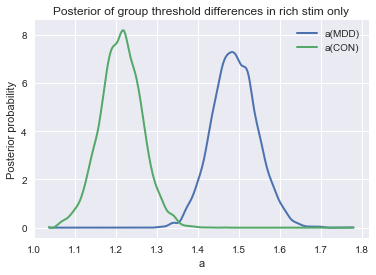

In [92]:
a_MDD_lean, a_CTL_lean = lean_acc_group.nodes_db.node[['a(MDD)','a(CON)']]
hddm.analyze.plot_posterior_nodes([a_MDD_lean, a_CTL_lean])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of group threshold differences in rich stim only')

print ("P_a(MDD > CTL) = ", (a_MDD_lean.trace() > a_CTL_lean.trace()).mean())
print ("P_a(CTL > MDD) = ", (a_CTL_lean.trace() > a_MDD_lean.trace()).mean())

Do drift rate or threshold for rich/lean stim correlate with anhedonia?

In [121]:
# Rich...
rich_acc_group_stats = rich_acc_group.gen_stats()
rich_acc_group_stats.to_csv('rich_acc_group_stats.csv')
rich_acc_group_stats = pd.read_csv('rich_acc_group_stats.csv')
rich_acc_group_stats.rename(columns={'Unnamed: 0': 'to_extract'}, inplace=True)

# get column info and merge this with the clinical data
rich_acc_group_stats = rich_acc_group_stats[['to_extract', 'mean']]
rich_acc_group_stats['param'] = rich_acc_group_stats.to_extract.apply(get_param)
rich_acc_group_stats['group'] = rich_acc_group_stats.to_extract.apply(get_group)
rich_acc_group_stats['subject'] = rich_acc_group_stats.to_extract.apply(get_id)
rich_acc_group_stats.subject = rich_acc_group_stats.subject.astype(str).apply(lambda x: x.zfill(3))
rich_acc_group_stats = pd.merge(rich_acc_group_stats, groups, on='subject')
rich_acc_group_stats.head()

,to_extract,mean,param,group_x,subject,exclude,group_y,age,sex,BDItotal,...,avT1_3,avrhT1_3,avlnT1_3,avshT1_3,avlgT1_3,MASQ_AD,avrhT1_4,avlnT1_4,avshT1_4,avlgT1_4
0,a_subj(CON).61,1.113471,a,CON,061,0.0,CON,27,f,4,...,454.399994,426.600006,485.288879,485.288879,426.600006,40.0,435.516785,483.65277,483.652771,435.51679
1,v_subj(CON).61,3.060069,v,CON,061,0.0,CON,27,f,4,...,454.399994,426.600006,485.288879,485.288879,426.600006,40.0,435.516785,483.65277,483.652771,435.51679
2,a_subj(CON).62,1.458330,a,CON,062,0.0,CON,45,f,1,...,967.670105,919.645813,"1,014.714294","1,014.714294",919.645813,53.0,943.952698,"1,025.62158","1,025.621582",943.95270
3,v_subj(CON).62,2.096958,v,CON,062,0.0,CON,45,f,1,...,967.670105,919.645813,"1,014.714294","1,014.714294",919.645813,53.0,943.952698,"1,025.62158","1,025.621582",943.95270
4,a_subj(CON).66,0.990359,a,CON,066,0.0,CON,47,m,0,...,359.369995,348.019989,370.720001,370.720001,348.019989,46.0,357.255035,379.12082,379.120819,357.25504



	Pearson's product-moment correlation

data:  rich_acc_group_stats_param$mean and rich_acc_group_stats_param$MASQ_AD
t = -0.087429, df = 19, p-value = 0.9312
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4478633  0.4152278
sample estimates:
        cor 
-0.02005358 




	Pearson's product-moment correlation

data:  rich_acc_group_stats_param$mean and rich_acc_group_stats_param$MASQ_AD
t = -2.1477, df = 19, p-value = 0.04485
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.73367944 -0.01271372
sample estimates:
       cor 
-0.4419748 



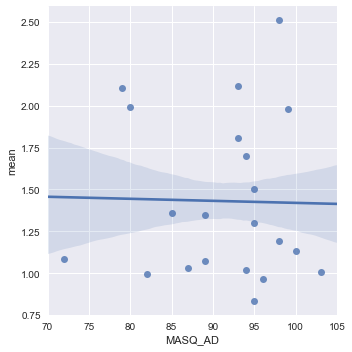

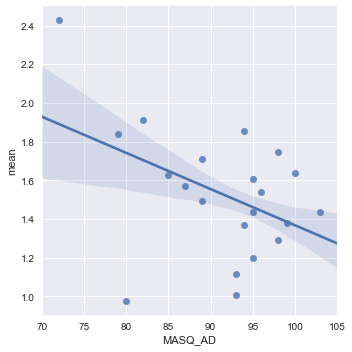

In [131]:
# for MDD subjects, are there any correlations with anhedonia and a parameter in the rich stim?

params = ['v','a']
for param in params:
    rich_acc_group_stats_param = rich_acc_group_stats[rich_acc_group_stats['param'] == param]
    rich_acc_group_stats_param = rich_acc_group_stats_param[rich_acc_group_stats_param['group_x'] == 'MDD']
    corr_param = sns.lmplot(y='mean', x = 'MASQ_AD', data=rich_acc_group_stats_param,ci=68)

    %Rpush rich_acc_group_stats_param
    %R corr_param <- cor.test(rich_acc_group_stats_param$mean,rich_acc_group_stats_param$MASQ_AD,method="pearson")
    %R print (corr_param)

Looks like threshold for the rich stim is significantly correlated with anhedonia in MDDs. 


	Pearson's product-moment correlation

data:  rich_acc_group_stats_param$mean and rich_acc_group_stats_param$MASQ_AD
t = -3.0731, df = 34, p-value = 0.004155
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.6892103 -0.1626213
sample estimates:
       cor 
-0.4662469 




	Pearson's product-moment correlation

data:  rich_acc_group_stats_param$mean and rich_acc_group_stats_param$MASQ_AD
t = 1.5318, df = 34, p-value = 0.1348
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.08123582  0.53772994
sample estimates:
      cor 
0.2540811 



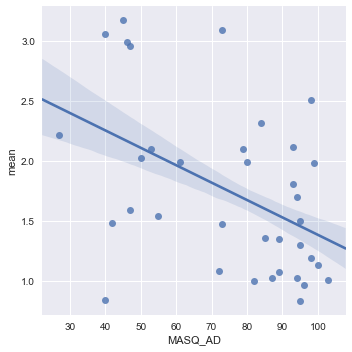

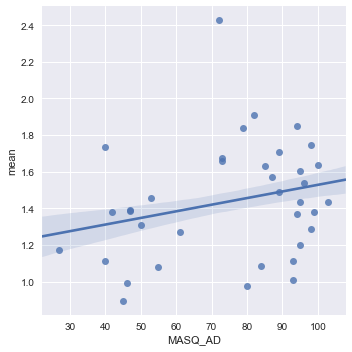

In [132]:
# Does it hold if we add in the controls?
# No it doesn't, and we get a correlation with drift rate. 

params = ['v','a']
for param in params:
    rich_acc_group_stats_param = rich_acc_group_stats[rich_acc_group_stats['param'] == param]
    corr_param = sns.lmplot(y='mean', x = 'MASQ_AD', data=rich_acc_group_stats_param,ci=68)

    %Rpush rich_acc_group_stats_param
    %R corr_param <- cor.test(rich_acc_group_stats_param$mean,rich_acc_group_stats_param$MASQ_AD,method="pearson")
    %R print (corr_param)

In [134]:
# Lean...
lean_acc_group_stats = lean_acc_group.gen_stats()
lean_acc_group_stats.to_csv('lean_acc_group_stats.csv')
lean_acc_group_stats = pd.read_csv('lean_acc_group_stats.csv')
lean_acc_group_stats.rename(columns={'Unnamed: 0': 'to_extract'}, inplace=True)

# get column info and merge this with the clinical data
lean_acc_group_stats = lean_acc_group_stats[['to_extract', 'mean']]
lean_acc_group_stats['param'] = lean_acc_group_stats.to_extract.apply(get_param)
lean_acc_group_stats['group'] = lean_acc_group_stats.to_extract.apply(get_group)
lean_acc_group_stats['subject'] = lean_acc_group_stats.to_extract.apply(get_id)
lean_acc_group_stats.subject = lean_acc_group_stats.subject.astype(str).apply(lambda x: x.zfill(3))
lean_acc_group_stats = pd.merge(lean_acc_group_stats, groups, on='subject')
lean_acc_group_stats.head()

,to_extract,mean,param,group_x,subject,exclude,group_y,age,sex,BDItotal,...,avT1_3,avrhT1_3,avlnT1_3,avshT1_3,avlgT1_3,MASQ_AD,avrhT1_4,avlnT1_4,avshT1_4,avlgT1_4
0,a_subj(CON).61,1.355843,a,CON,061,0.0,CON,27,f,4,...,454.399994,426.600006,485.288879,485.288879,426.600006,40.0,435.516785,483.65277,483.652771,435.51679
1,v_subj(CON).61,2.287866,v,CON,061,0.0,CON,27,f,4,...,454.399994,426.600006,485.288879,485.288879,426.600006,40.0,435.516785,483.65277,483.652771,435.51679
2,a_subj(CON).62,1.241340,a,CON,062,0.0,CON,45,f,1,...,967.670105,919.645813,"1,014.714294","1,014.714294",919.645813,53.0,943.952698,"1,025.62158","1,025.621582",943.95270
3,v_subj(CON).62,0.771602,v,CON,062,0.0,CON,45,f,1,...,967.670105,919.645813,"1,014.714294","1,014.714294",919.645813,53.0,943.952698,"1,025.62158","1,025.621582",943.95270
4,a_subj(CON).66,1.053033,a,CON,066,0.0,CON,47,m,0,...,359.369995,348.019989,370.720001,370.720001,348.019989,46.0,357.255035,379.12082,379.120819,357.25504



	Pearson's product-moment correlation

data:  lean_acc_group_stats_param$mean and lean_acc_group_stats_param$MASQ_AD
t = 1.3744, df = 19, p-value = 0.1853
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1505090  0.6482502
sample estimates:
      cor 
0.3007161 




	Pearson's product-moment correlation

data:  lean_acc_group_stats_param$mean and lean_acc_group_stats_param$MASQ_AD
t = -0.48757, df = 19, p-value = 0.6314
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5179927  0.3366800
sample estimates:
       cor 
-0.1111633 



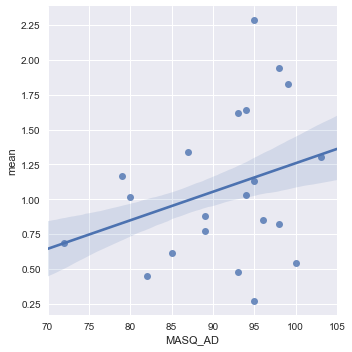

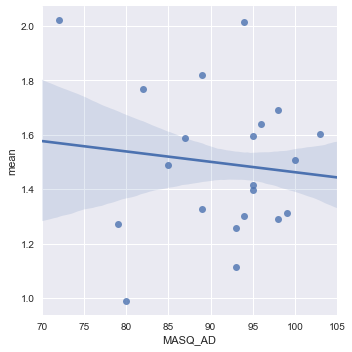

In [135]:
# for MDD subjects, are there any correlations with anhedonia and a parameter in the lean stim?
# Nope

params = ['v','a']
for param in params:
    lean_acc_group_stats_param = lean_acc_group_stats[lean_acc_group_stats['param'] == param]
    lean_acc_group_stats_param = lean_acc_group_stats_param[lean_acc_group_stats_param['group_x'] == 'MDD']
    corr_param = sns.lmplot(y='mean', x = 'MASQ_AD', data=lean_acc_group_stats_param,ci=68)

    %Rpush lean_acc_group_stats_param
    %R corr_param <- cor.test(lean_acc_group_stats_param$mean,lean_acc_group_stats_param$MASQ_AD,method="pearson")
    %R print (corr_param)

### Back to stim coded; below are two models for MDDs and CTLs with block as a within factor

In [93]:
ddm_data_resp = hddm.load_csv('sigdep_ddm_data_resp_coded.csv')

In [94]:
ctl_resp_data = ddm_data_resp.loc[ddm_data_resp.group == 'CON']
ctl_stim_block = hddm.HDDMRegressor(ctl_resp_data, ['v ~ 0 + C(block)', 'a ~ 0 + C(block)'])
ctl_stim_block.sample(10000, burn=1000, dbname = 'ctl_stim_block', db='pickle')
ctl_stim_block.save('ctl_stim_block')

Adding these covariates:
['v_C(block)[1.0]', 'v_C(block)[2.0]', 'v_C(block)[3.0]']
Adding these covariates:
['a_C(block)[1.0]', 'a_C(block)[2.0]', 'a_C(block)[3.0]']
 [-----------------100%-----------------] 10001 of 10000 complete in 14046.6 secWARNING: Will not save custom link functions.


In [112]:
ctl_stim_block.dic_info

{'DIC': 2761.9727980051007,
 'deviance': 2628.2171535708662,
 'pD': 133.75564443423445}

P_a(block1 > block2) =  0.811444444444
P_a(block2 > block3) =  0.434
P_a(block3 > block1) =  0.235111111111


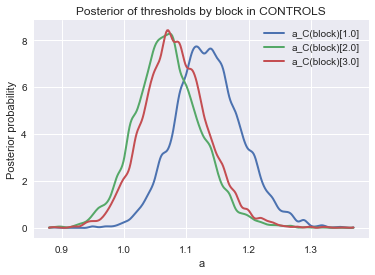

In [266]:
a_block1, a_block2, a_block3 = ctl_stim_block.nodes_db.node[['a_C(block)[1.0]','a_C(block)[2.0]','a_C(block)[3.0]']]
hddm.analyze.plot_posterior_nodes([a_block1, a_block2, a_block3])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of thresholds by block in CONTROLS')

print ("P_a(block1 > block2) = ", (a_block1.trace() > a_block2.trace()).mean())
print ("P_a(block2 > block3) = ", (a_block2.trace() > a_block3.trace()).mean())
print ("P_a(block3 > block1) = ", (a_block3.trace() > a_block1.trace()).mean())

P_v(block1 > block2) =  0.218111111111
P_v(block2 > block3) =  0.396777777778
P_v(block1 > block3) =  0.141222222222


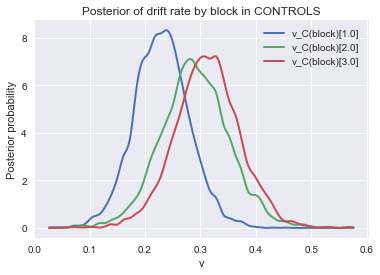

In [267]:
v_block1, v_block2, v_block3 = ctl_stim_block.nodes_db.node[['v_C(block)[1.0]','v_C(block)[2.0]','v_C(block)[3.0]']]
hddm.analyze.plot_posterior_nodes([v_block1, v_block2, v_block3])
plt.xlabel('v')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate by block in CONTROLS')

print ("P_v(block1 > block2) = ", (v_block1.trace() > v_block2.trace()).mean())
print ("P_v(block2 > block3) = ", (v_block2.trace() > v_block3.trace()).mean())
print ("P_v(block1 > block3) = ", (v_block1.trace() > v_block3.trace()).mean())

In [114]:
mdd_resp_data = ddm_data_resp.loc[ddm_data_resp.group == 'MDD']
mdd_stim_block = hddm.HDDMRegressor(mdd_resp_data, ['v ~ 0 + C(block)', 'a ~ 0 + C(block)'])
mdd_stim_block.sample(10000, burn=1000, dbname='mdd_stim_block', db='pickle')
mdd_stim_block.save('mdd_stim_block')

Adding these covariates:
['v_C(block)[1.0]', 'v_C(block)[2.0]', 'v_C(block)[3.0]']
Adding these covariates:
['a_C(block)[1.0]', 'a_C(block)[2.0]', 'a_C(block)[3.0]']
 [-------------    35%                  ] 3527 of 10000 complete in 4464.4 secHalting at iteration  3526  of  10000


In [113]:
mdd_stim_block.dic_info

NameError: name 'mdd_stim_block' is not defined

P_a(block1 > block2) =  0.892444444444
P_a(block2 > block3) =  0.618333333333
P_a(block3 > block1) =  0.0703333333333


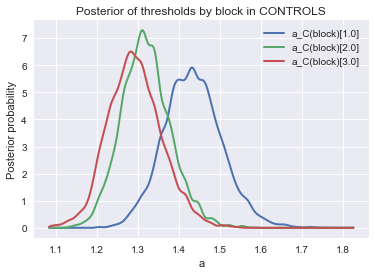

In [270]:
a_block1, a_block2, a_block3 = mdd_stim_block.nodes_db.node[['a_C(block)[1.0]','a_C(block)[2.0]','a_C(block)[3.0]']]
hddm.analyze.plot_posterior_nodes([a_block1, a_block2, a_block3])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of thresholds by block in CONTROLS')

print ("P_a(block1 > block2) = ", (a_block1.trace() > a_block2.trace()).mean())
print ("P_a(block2 > block3) = ", (a_block2.trace() > a_block3.trace()).mean())
print ("P_a(block3 > block1) = ", (a_block3.trace() > a_block1.trace()).mean())

P_v(block1 > block2) =  0.800111111111
P_v(block2 > block3) =  0.368666666667
P_v(block1 > block3) =  0.291111111111


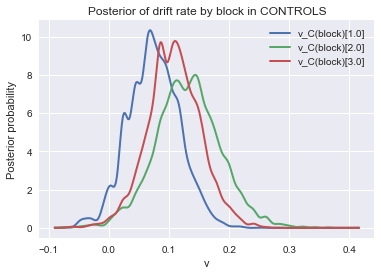

In [271]:
v_block1, v_block2, v_block3 = mdd_within_block.nodes_db.node[['v_C(block)[1.0]','v_C(block)[2.0]','v_C(block)[3.0]']]
hddm.analyze.plot_posterior_nodes([v_block1, v_block2, v_block3])
plt.xlabel('v')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift rate by block in CONTROLS')

print ("P_v(block1 > block2) = ", (v_block1.trace() < v_block2.trace()).mean())
print ("P_v(block2 > block3) = ", (v_block2.trace() < v_block3.trace()).mean())
print ("P_v(block1 > block3) = ", (v_block1.trace() > v_block3.trace()).mean())

So from above it looks like drift rates in both groups get slightly faster, and thresholds get slightly smaller for each block, but nothing is significant or particularly interesting.

### 3 stimulus coded models for each block that depend on group

In [95]:
block1_resp_data = ddm_data_resp.loc[ddm_data_resp.block == 1]
block2_resp_data = ddm_data_resp.loc[ddm_data_resp.block == 2]
block3_resp_data = ddm_data_resp.loc[ddm_data_resp.block == 3]
block1_resp_data.head()

,Unnamed: 0,Unnamed: 0.1,subj_idx,date,bias,short_key,long_key,trial,length,rt,...,excluded,Group#,Group,block,block_RB,block_disc,rich_lean,rich_key,stim,response
0,0,0,39,6/15/2004,short,/,z,1,short,0.499,...,0,0,MDD,1.0,0.257556,0.577891,rich,/,1,1
1,1,1,39,6/15/2004,short,/,z,2,long,0.628,...,0,0,MDD,1.0,0.257556,0.577891,lean,/,0,0
2,2,2,39,6/15/2004,short,/,z,3,short,0.705,...,0,0,MDD,1.0,0.257556,0.577891,rich,/,1,1
3,3,3,39,6/15/2004,short,/,z,4,long,0.588,...,0,0,MDD,1.0,0.257556,0.577891,lean,/,0,0
4,4,4,39,6/15/2004,short,/,z,5,short,0.667,...,0,0,MDD,1.0,0.257556,0.577891,rich,/,1,0


In [97]:
block1_stim_group_m = hddm.HDDM(block1_resp_data, depends_on={'v': 'Group', 'a': 'Group'})
block1_stim_group_m.sample(10000, burn=1000, dbname = 'block1_stim_group.db', db= 'pickle')
block1_stim_group_m.save('block1_stim_group')

In [99]:
block1_stim_group_m.dic_info

{'DIC': 4097.719732646362,
 'deviance': 3993.4895271032874,
 'pD': 104.23020554307459}

In [100]:
block2_stim_group_m = hddm.HDDM(block2_resp_data, depends_on={'v': 'Group', 'a': 'Group'})
block2_stim_group_m.sample(10000, burn=1000, dbname = 'block2_stim_group.db', db = 'pickle')
block2_stim_group_m.save('block2_stim_group')

 [-----------------100%-----------------] 10000 of 10000 complete in 431.8 sec

In [101]:
block2_stim_group_m.dic_info

{'DIC': 3068.8442015431101,
 'deviance': 2953.299096225182,
 'pD': 115.54510531792812}

In [102]:
block3_stim_group_m = hddm.HDDM(block3_resp_data, depends_on={'v': 'Group', 'a': 'Group'})
block3_stim_group_m.sample(10000, burn=1000, dbname = 'block3_stim_group.db', db = 'pickle')
block3_stim_group_m.save('block3_stim_group')

 [-----------------100%-----------------] 10000 of 10000 complete in 447.6 sec

In [104]:
block3_stim_group_m.dic_info

{'DIC': 3039.8622085343713,
 'deviance': 2929.1692006507274,
 'pD': 110.69300788364399}

In each block, do the drift rates differ between groups?

P_v(MDD > CON) =  0.00611111111111
P_v(CON > MDD) =  0.993888888889


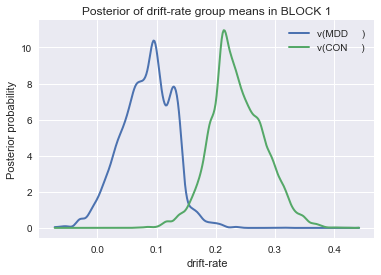

In [103]:
v_MDD, v_CON = block1_stim_group_m.nodes_db.node[['v(MDD     )','v(CON     )']]
hddm.analyze.plot_posterior_nodes([v_MDD, v_CON])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means in BLOCK 1')

print ("P_v(MDD > CON) = ", (v_MDD.trace() > v_CON.trace()).mean())
print ("P_v(CON > MDD) = ", (v_CON.trace() > v_MDD.trace()).mean())

P_v(MDD > CON) =  0.0203333333333
P_v(CON > MDD) =  0.979666666667


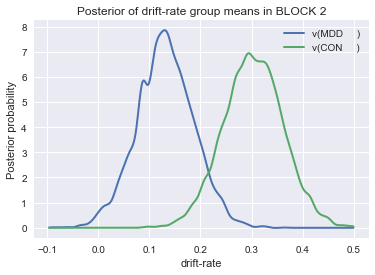

In [105]:
v_MDD, v_CON = block2_stim_group_m.nodes_db.node[['v(MDD     )','v(CON     )']]
hddm.analyze.plot_posterior_nodes([v_MDD, v_CON])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means in BLOCK 2')

print ("P_v(MDD > CON) = ", (v_MDD.trace() > v_CON.trace()).mean())
print ("P_v(CON > MDD) = ", (v_CON.trace() > v_MDD.trace()).mean())

P_v(MDD > CON) =  0.00288888888889
P_v(CON > MDD) =  0.997111111111


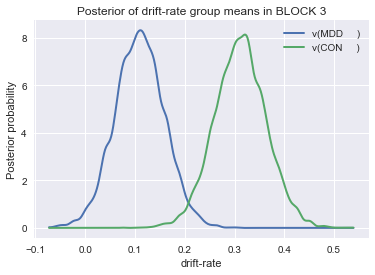

In [106]:
v_MDD, v_CON = block3_stim_group_m.nodes_db.node[['v(MDD     )','v(CON     )']]
hddm.analyze.plot_posterior_nodes([v_MDD, v_CON])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means in BLOCK 3')

print ("P_v(MDD > CON) = ", (v_MDD.trace() > v_CON.trace()).mean())
print ("P_v(CON > MDD) = ", (v_CON.trace() > v_MDD.trace()).mean())

Seems like the MDDs always have slower drift rates, and that this doesn't change over time. 

In each block, do the response thresholds differ between groups?

P_a(MDD > CON) =  0.999888888889
P_a(CON > MDD) =  0.000111111111111


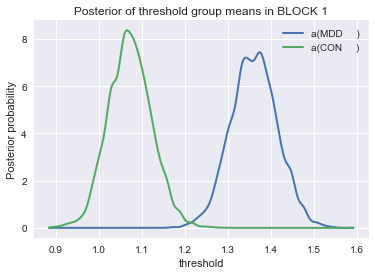

In [107]:
a_MDD, a_CON = block1_stim_group_m.nodes_db.node[['a(MDD     )','a(CON     )']]
hddm.analyze.plot_posterior_nodes([a_MDD, a_CON])
plt.xlabel('threshold')
plt.ylabel('Posterior probability')
plt.title('Posterior of threshold group means in BLOCK 1')

print ("P_a(MDD > CON) = ", (a_MDD.trace() > a_CON.trace()).mean())
print ("P_a(CON > MDD) = ", (a_CON.trace() > a_MDD.trace()).mean())

P_a(MDD > CON) =  0.999777777778
P_a(CON > MDD) =  0.000222222222222


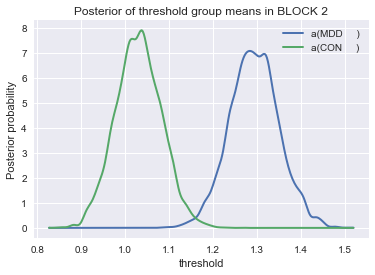

In [108]:
a_MDD, a_CON = block2_stim_group_m.nodes_db.node[['a(MDD     )','a(CON     )']]
hddm.analyze.plot_posterior_nodes([a_MDD, a_CON])
plt.xlabel('threshold')
plt.ylabel('Posterior probability')
plt.title('Posterior of threshold group means in BLOCK 2')

print ("P_a(MDD > CON) = ", (a_MDD.trace() > a_CON.trace()).mean())
print ("P_a(CON > MDD) = ", (a_CON.trace() > a_MDD.trace()).mean())

P_a(MDD > CON) =  0.991777777778
P_a(CON > MDD) =  0.00822222222222


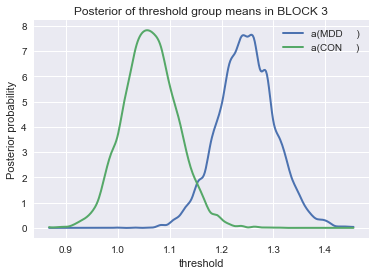

In [109]:
a_MDD, a_CON = block3_stim_group_m.nodes_db.node[['a(MDD     )','a(CON     )']]
hddm.analyze.plot_posterior_nodes([a_MDD, a_CON])
plt.xlabel('threshold')
plt.ylabel('Posterior probability')
plt.title('Posterior of threshold group means in BLOCK 3')

print ("P_a(MDD > CON) = ", (a_MDD.trace() > a_CON.trace()).mean())
print ("P_a(CON > MDD) = ", (a_CON.trace() > a_MDD.trace()).mean())

The MDDs have higher decision thresholds, this doesn't change by block.